In [1]:
!pip install wandb

In [2]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ma23m013 (ma23m013-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Question-1

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


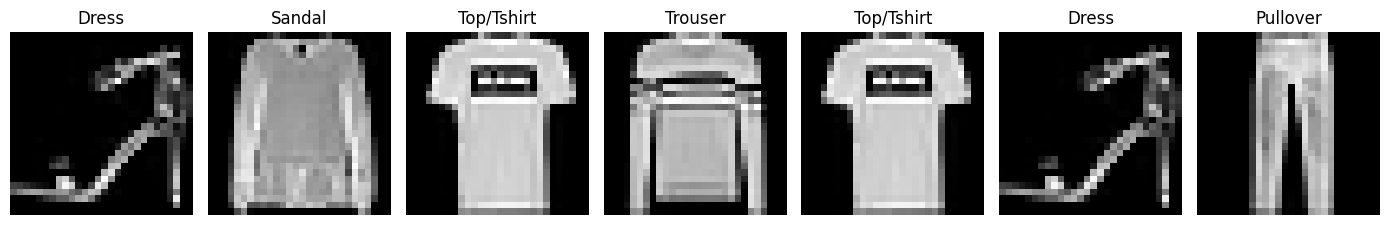

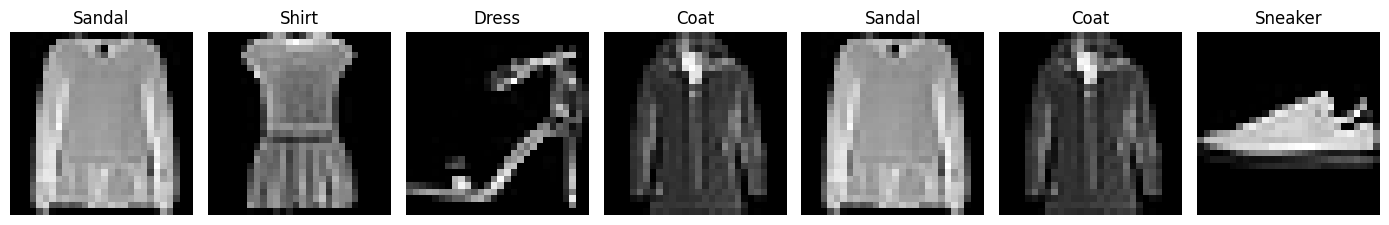

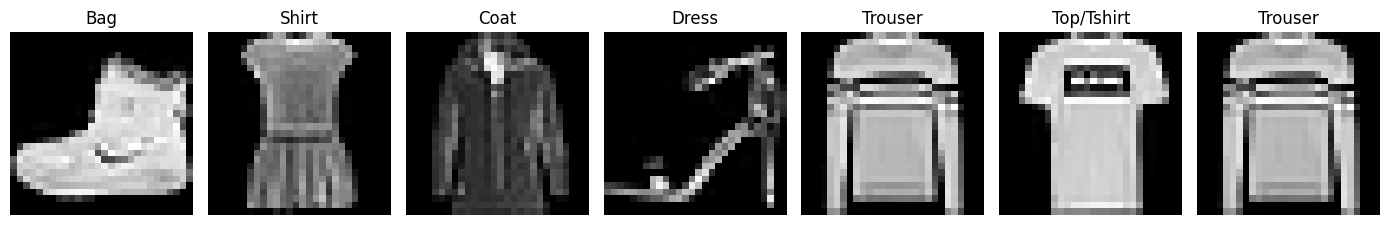

In [ ]:
# Initialize WandB project
wandb.init(project='DA6401_Assignment-1')

# Load Fashion-MNIST dataset (train and test sets)
(train_img, train_lbl), (test_img, test_lbl) = fashion_mnist.load_data()

# Define class names for labels
class_names = ['Top/Tshirt', 'Pullover', 'Trouser', 'Shirt', 'Coat', 'Dress', 'Sandal', 'Sneaker', 'Ankle-boot', 'Bag']

# Select one sample image for each class
samples = {}
for i in range(100):  # Loop through first 36 images
  lbl = train_lbl[i]  # Get label of current image
  if lbl not in samples:  # If label is not already added, add it
    samples[lbl] = train_img[i]
  if len(samples) == 10:  # Stop when all 10 classes have at least one image
    break

# Convert dictionary to lists for easy indexing
sample_lbl = list(samples.keys())
sample_img = list(samples.values())

# Function to plot 7 random sample images
def plot_sample(step):
  fig, axes = plt.subplots(1, 7, figsize=(14, 5))  # Create figure with 7 subplots
  chosen_indices = np.random.choice(len(sample_img), 7, replace=True)  # Randomly select 7 images

  for ax, idx in zip(axes.flatten(), chosen_indices):
    ax.imshow(sample_img[idx], cmap='gray')  # Display image
    ax.set_title(class_names[sample_lbl[idx]])  # Set title with class name
    ax.axis('off')  # Remove axis for cleaner view

  plt.tight_layout()
  plt.show()
  return fig

# Log images to WandB for visualization
wandb.log({"Examples": [wandb.Image(plot_sample(0), caption="Step 0"),
    wandb.Image(plot_sample(1), caption="Step 1"), wandb.Image(plot_sample(2), caption="Step 2")]})

# Finish WandB run
wandb.finish()


## Question-2

In [8]:
# Activation function (Sigmoid)
def act(x):
  return 1/(1+np.exp(-x))  # Converts input into a range between 0 and 1

# Derivative of Sigmoid, used in backpropagation to compute gradients
def act_der(x):
  return act(x)*(1-act(x))

# Softmax function, converts output layer activations into probabilities
def soft_func(x):
  x = x-np.max(x) # Normalize values to prevent overflow
  return np.exp(x)/np.sum(np.exp(x), axis=0)

# Initialize neural network weights and biases
def init_net(n_layers, nodes, init_m, inp_dim, out_dim):
  size = [inp_dim]+nodes+[out_dim]  # Define the structure of the network
  wts = {}  # Dictionary to store weights and biases

  if init_m == 'rand': # Random weight initialization
    for i in range(1, n_layers+2):
      wts['W'+str(i)] = np.random.randn(size[i],size[i-1])
      wts['b'+str(i)] = np.random.randn(size[i],1)
  elif init_m == 'xav': # Xavier initialization for better weight scaling
    for i in range(1, n_layers+2):
      wts['W'+str(i)] = np.random.randn(size[i],size[i-1])*(np.sqrt(2/size[i-1]))
      wts['b'+str(i)] = np.random.randn(size[i],1)*(np.sqrt(2/size[i-1]))

  return wts

# Forward propagation - calculates activations layer by layer
def forw_prop(inp,wts, n_layers, inp_dim):
  acts = {} # Store activation values
  acts['a0'] = np.zeros(inp_dim,1) # Initialize first activation
  out = {'h0':inp} # Store input layer values

  for i in range(1,n_layers+1): # Iterate through hidden layers
    acts['a'+str(i)]= np.dot(wts['W'+str(i)], out['h'+str(i-1)]) + wts['b'+str(i)]
    out['h'+str(i)]= act(acts['a'+str(i)]) # Apply activation function
  # Output layer processing
  acts['a'+str(n_layers+1)]= np.dot(wts['W'+str(n_layers+1)], out['h'+str(n_layers)]) + wts['b'+str(n_layers+1)]
  pred = soft_func(acts['a'+str(n_layers+1)]) # Apply softmax for probabilities

  return acts, out, pred

# Backpropagation - calculates gradients for weight updates
def back_prop(inp, true_lbl, n_layers, wts, inp_dim):
  m = inp.shape[0] # Number of examples
  acts, out, pred = forw_prop(inp, wts, n_layers, inp_dim)
  grad = {} # Store gradients
  err = {} # Store error terms
  err['a'+str(n_layers+1)] = -1*(true_lbl.T-pred) # Compute error for output layer

  for i in range(n_layers+1,0,-1): # Iterate backwards through layers
    grad['W'+str(i)]= (1/m)*np.dot(err['a'+str(i)], out['h'+str(i-1)].T) # Compute weight gradient
    grad['b'+str(i)]= (1/m)*np.mean(err['a'+str(i)], axis=1, keepdims=True) # Compute bias gradient
    err['h'+str(i-1)]= np.dot(wts['W'+str(i)].T, err['a'+str(i)]) # Propagate error backward
    err['a'+str(i-1)]= err['h'+str(i-1)]*act_der(acts['a'+str(i-1)]) # Apply derivative of activation
  return grad

# Gradient Descent with loss tracking
def upd_wts(lr, wts, inp, true_lbl, n_layers, inp_dim):
  losses= []  # Store losses for each epoch
  for e in range(100): # Train for 100 epochs
    grad = back_prop(inp, true_lbl, n_layers, wts, inp_dim)
    for i in range (1, n_layers+2):
      wts['W'+str(i)] -= lr*grad['W'+str(i)] # Update weights
      wts['b'+str(i)] -= lr*grad['b'+str(i)] # Update biases

    # Compute loss for this epoch
    acts, out, pred = forw_prop(inp, wts, n_layers, inp_dim)
    loss = -np.mean(np.sum(true_lbl.T*np.log(pred),axis=0))
    losses.append(loss)
    print(f'Epoch {e+1}, Loss: {loss}')

  # Plot the loss function over epochs
  plt.plot(losses)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training Loss over Epochs')
  plt.show()

  return wts,losses

# Compute accuracy of the model
def calc_acc(test_inp, test_lbl, wts, n_layers, inp_dim):
  acts, out, pred = forw_prop(test_inp, wts, n_layers, inp_dim)
  assert test_lbl.shape == pred.shape # Ensure shapes match
  test_lbl = np.argmax(test_lbl, axis=0) # Convert one-hot labels to index
  pred = np.argmax(pred, axis=0) # Get predicted class
  correct = np.sum(test_lbl==pred) # Count correct predictions
  acc = correct/test_lbl.shape[0] # Compute accuracy

  return acc